## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math
from PIL import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

%matplotlib inline
#%matplotlib qt

## Global variables

In [2]:
path_camera_calibration = './camera_cal/'
path_test_images = './test_images/'
path_ouput_images = './output_images/'

pickle_file = 'wide_dist_pickle.p'
input_video = 'project_video.mp4'

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d points in real world space
img_points = [] # 2d points in image plane.

# Make a list of calibration images
images_list = glob.glob(path_camera_calibration + 'calibration*.jpg')
chessboard_images = []
undistorted_images = []

# dictionary for creating binary file for calibration data
dist_pickle = {}

# mask values
top_left = [600, 450]
top_right = [700, 450]
bottom_left = [200, 720]
bottom_right = [1190, 720]

proj_top_left = [500, -100]
proj_top_right = [1000, -100]
proj_bottom_left = [400, 720]
proj_bottom_right = [1000, 720]

# check for camera calibration directory
if not os.path.exists(path_camera_calibration):
    os.makedirs(path_camera_calibration)
    
# check for test images directory
if not os.path.exists(path_test_images):
    os.makedirs(path_test_images)

# check for output images directory
if not os.path.exists(path_ouput_images):
    os.makedirs(path_ouput_images)

## Helper functions

In [3]:
def get_output_file_path(filename):
    '''creates output path for images and returns it'''
    return path_ouput_images + filename + '.jpg'

def save_output_file(img, filename):
    '''saves the image as file'''
    mpimg.imsave(get_output_file_path(filename), img)

## Pipeline functions

In [4]:
def calibration_undistort(img, obj_points, img_points):
    '''performs the camera calibration, image distortion correction and 
    returns the undistorted image'''
    
    # defined image size
    img_size = (img.shape[1], img.shape[0])
    
    # calibrate camera and return parameters 
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    
    # undistrot image based on calibration parameters
    undist = cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix)
    
    return undist


def combined_binary(img, s_thresh=(90, 255), sx_thresh=(20, 100), r_thresh = (200, 255)):
    '''performs several steps like channel selection
    sobel operators and color thresholding for creating binary image'''
    
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(s_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    g_binary = np.zeros_like(g_channel)
    g_binary[(g_channel > r_thresh[0]) & (g_channel <= r_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( r_binary, sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (l_binary == 1)) | ((r_binary == 1) & (g_binary == 1)) | (sxbinary == 1)] = 1
    
    #(S&L) | (R&G) | Gx
    
    return combined_binary

def region_of_interest(img, vertices=None):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    if vertices == None:
#         vertices = np.array([[(0, image.shape[0]),
#                           (x_axis_mask_left, y_axis_mask), 
#                           (x_axis_mask_right, y_axis_mask), 
#                           (image.shape[1], image.shape[0])]
#                         ], dtype=np.int32)
        
        
        vertices = np.array([[bottom_left,
                          top_left, 
                          top_right, 
                          bottom_right]
                        ], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp(img):
    '''Define calibration box in source (original) and destination (desired or warped) coordinates'''
    
    # get image size
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [bottom_left,
         top_left,
         top_right,
         bottom_right])    
    
    
    # Four desired coordinates
    dst = np.float32(
        [proj_bottom_left,
         proj_top_left,
         proj_top_right,
         proj_bottom_right])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linera interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

## Camera Calibration

In [5]:
dimensions = (9,6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
obj_p = np.zeros((6*9, 3), np.float32)
obj_p[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Step through the list and search for chessboard corners
for fname in images_list:
    # Read each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, dimensions, None)

    # If corners are found, add object points, image points and image to images array
    if ret == True:
        obj_points.append(obj_p)
        img_points.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, dimensions, corners, ret)
        chessboard_images.append(img)

In [6]:
# save output image
save_output_file(chessboard_images[0], 'camera_calibration')

In [7]:
# save points to pickle file for later use
dist_pickle['obj_points'] = obj_points
dist_pickle['img_points'] = img_points
pickle.dump(dist_pickle, open(path_camera_calibration + pickle_file, 'wb'))

## Correction for Distortion

In [8]:
# Read in the saved points and points from pickle file for usage
dist_pickle = pickle.load(open(path_camera_calibration + pickle_file, 'rb'))
obj_points = dist_pickle['obj_points']
img_points = dist_pickle['img_points']

### Test calibration and distortion correction

In [9]:
test_images_list = glob.glob(path_test_images + 'test*.jpg')
undistorted_images = []

# read in images and append to images
for fname in test_images_list:
    # Read each image
    img = mpimg.imread(fname)
    
    # Undistort the image
    dst = calibration_undistort(img, obj_points, img_points)
    
    # append to list
    undistorted_images.append(dst)

In [10]:
# save output image
save_output_file(undistorted_images[0], 'raw_undistorted')

## Pipeline

In [11]:
def pipeline(image, save_ouput_file=True):
    '''perfomrs pipeline on input image'''
    
    # undistorted image
    undistorted = calibration_undistort(image, obj_points, img_points)
    
#     pts = np.int32(
#         [top_right,
#          top_left,
#          bottom_left,
#          bottom_right])
#     #pts = pts.reshape((-1,1,2))
#     cv2.polylines(undistorted, [pts], True, (255,0,0), 3, lineType=cv2.LINE_AA)

    if save_ouput_file==True:
        # save output image
        save_output_file(undistorted, 'pip_raw_undistorted')
        print("Undistorted")
        plt.imshow(undistorted)
        plt.show()
        
    # Show masked image for check
    masked_image = region_of_interest(image)
    if save_ouput_file==True:
        # save output image
        save_output_file(masked_image, 'pip_masked')
        print("Masked")
        plt.imshow(masked_image)
        plt.show()
        
    # binary image    
    binary = combined_binary(undistorted)

#     ksize = 5 # Choose a larger odd number to smooth gradient measurements
#     gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 50))
#     grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 70))
#     mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 100))
#     dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(4*np.pi/16, np.pi/2))

#     binary = np.zeros_like(dir_binary)
#     binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    if save_ouput_file==True:
        # save output image
        save_output_file(binary, 'pip_binary')
        print("Binary")
        plt.imshow(binary, cmap='gray')
        plt.show()
        
    # warped image
    warped = warp(binary)
    if save_ouput_file==True:
        # save output image
        save_output_file(warped, 'pip_warped')
        print("Warped")
        plt.imshow(warped, cmap='gray')
        plt.show()
    
     # save output image
#     save_output_file(combined_binary, 'pip_combined_binary')


    # Onl the first pipline should save output images
    save_ouput_file = False
    
    return None
    

## Read in video and apply pipeline on it

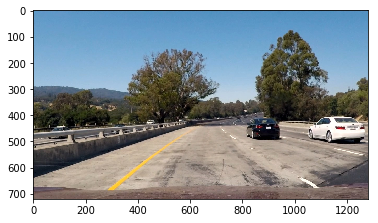

In [12]:
image = mpimg.imread(path_test_images + 'test1.jpg') 
plt.imshow(image)

Undistorted


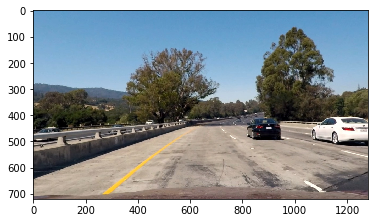

Masked


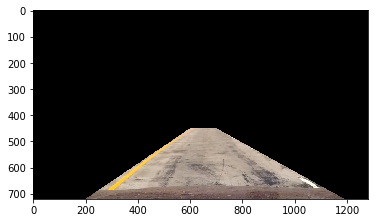

Binary


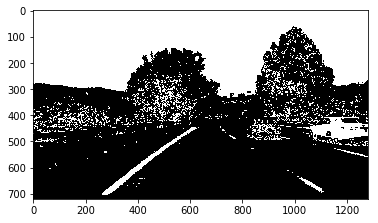

Warped


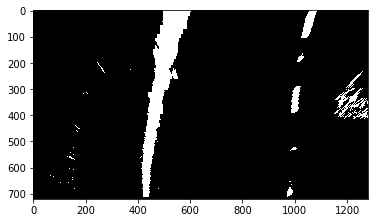

In [13]:
output = pipeline(image)